# Applied Data Analysis: CMU Movie Summary Corpus

## Dataset Details
This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## Part 1 : Understanding the data
In this section, we will begin by loading the dataset and performing some initial exploratory data analysis (EDA). This will help us understand the structure and content of the data, identify any missing values, and get a sense of the distributions and relationships between different variables.

In [50]:
# Imports
import importlib
from collections import Counter
import src.data.CMU_dataset_dataloader as CMU_dataset_dataloader
import src.utils.data_utils as data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import json

#%pip install SPARQLWrapper

importlib.reload(CMU_dataset_dataloader)
importlib.reload(data_utils)

# Constants
CMU_DATA_DOWNLOAD_PATH = 'https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
CMU_DATA_PATH_INITIAL = 'data/initial/'
CMU_DATA_PREPROCESSED_PATH = 'data/preprocessed/'

sns.set_palette("colorblind") 
sns.set_style("whitegrid")

### Load the plot summaries

In [51]:
print("Plot Summaries:")
plots = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'plot_summaries.txt', categories=['movie_id', 'summary'])
df_plots = plots.data

df_plots.sample(5)

Plot Summaries:


,movie_id,summary
32577,8445503,The film begins with shots of American bombers...
33531,101555,Set in post-World War II Yugoslavia during the...
36176,6071715,Mikey and his stepmother Rose are lovers and...
13309,31267756,"A former thief, Will Montgomery , is released ..."
19334,30981472,Raju and Urmila meet in New Zealand and fall...


### Plot summaries preprocessing

count    42303.000000
mean      1784.034300
std       1808.925641
min         99.000000
25%        508.000000
50%       1079.000000
75%       2604.500000
max      28159.000000
Name: summary_length, dtype: float64


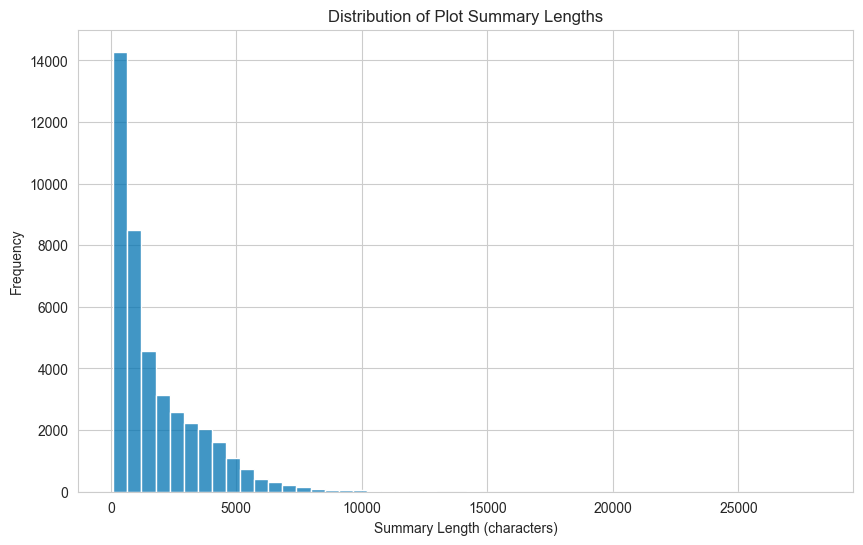

,movie_id,summary,summary_length
5331,27773433,Maxim Sarafanov has just been fired from the ...,418
6912,1128175,"{{quality}} In the year 2055, time travel is ...",7008
13254,35672493,Veysel loves a singer named Başak. But she don...,194
31842,15233369,"In Mumbai in 2006, eighteen-year-old Jamal Mal...",5369
18843,13149824,"In 12th Century India, a huge ruby was bestowe...",2189


In [52]:
# missing values
assert df_plots['summary'].isnull().sum() == 0
assert df_plots['movie_id'].isnull().sum() == 0

# Average plot summary length
df_plots['summary_length'] = df_plots['summary'].apply(len)
print(df_plots['summary_length'].describe())

df_plots.to_csv(CMU_DATA_PREPROCESSED_PATH + 'plot_summaries.csv', index=False)

# # Plotting summary lengths distribution
plt.figure(figsize=(10,6))
sns.histplot(df_plots['summary_length'], bins=50)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

# # Print the preprocessed summaries
df_plots.sample(5)

## Load the movie metadata

In [53]:
# Load the movie metadata
print("\nMovie Metadata:")
categories = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'release_date',
    'box_office_revenue',
    'runtime',
    'languages',
    'countries',
    'genres'
    ]
movies = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'movie.metadata.tsv', categories=categories)
df_movies = movies.data

df_movies.sample(5)


Movie Metadata:


,wikipedia_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres
52392,963052,/m/03tt1c,To Live and Die in L.A.,1985-11-01,17300000.0,116.0,"{""/m/0jzc"": ""Arabic Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
1287,73395,/m/0jq8r,The Cheat,1915-12-13,NaN,59.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
8353,2426058,/m/07c6yg,Proof,2005-09-30,14189860.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
56872,26304838,/m/0b77d9s,Mockery,1927-08-13,NaN,75.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
46074,23608176,/m/06zj_5d,The Reckoning: The Battle for the Internationa...,2009,NaN,96.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0cshrf"": ""Political cinema"", ""/m/03g3w"": ..."


As we can see here, there are is a lot of data which is not directly workable. The only way to go: preprocessing.

### Movie metadata preprocessing

Since our main goal is to predict the box office revenue of the movies, movies with missing revenue values will be removed from the dataset. We will also remove the freebase_movie_id column as it is not relevant for our analysis.

In [54]:
df_movies = df_movies.copy()

# Removing freebase (deprecated)
if 'freebase_movie_id' in df_movies.columns:
    df_movies.drop(columns=['freebase_movie_id'], inplace=True)

# missing values
df_movies = df_movies.dropna(subset=['box_office_revenue'])

assert df_movies['box_office_revenue'].isnull().sum() == 0

# Extracting the language values for all rows
df_movies['languages'] = df_movies['languages'].apply(data_utils.convert_to_dict)
df_movies['countries'] = df_movies['countries'].apply(data_utils.convert_to_dict)

Within the release date column there is important information that can be separated: Day, Month, and Year. Specific months and years can be crucial for box office revenue.

When we print of the years in our dataset, we can notice that there is a big gap between the first year and the following ones (1010 - 1897 - 1914). This also serves to highlight the importance of preprocessing, as it is obvious that there was no movie made in 1010. To avoid this type of outliers (and errors), we will only consider films from 1900 onwards.

In [55]:
# Format release date
df_movies['release_day'] = df_movies['release_date'].apply(data_utils.get_day)
df_movies['release_month'] = df_movies['release_date'].apply(data_utils.get_month)
df_movies['release_year'] = df_movies['release_date'].apply(data_utils.get_year)
df_movies.drop(columns=['release_date'], inplace=True)

# Remove movies with release year less than 1900
print("Years:", df_movies['release_year'].sort_values().unique())
df_movies = df_movies[df_movies['release_year'] >= 1900]

Years: [1010. 1897. 1914. 1915. 1920. 1921. 1922. 1923. 1924. 1925. 1926. 1927.
 1928. 1929. 1930. 1931. 1932. 1933. 1934. 1935. 1936. 1937. 1938. 1939.
 1940. 1941. 1942. 1943. 1944. 1945. 1946. 1947. 1948. 1949. 1950. 1951.
 1952. 1953. 1954. 1955. 1956. 1957. 1958. 1959. 1960. 1961. 1962. 1963.
 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973. 1974. 1975.
 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987.
 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999.
 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012.   nan]


Specifically for genres, we can notice that sometimes one can be divided into two, and other times two genres mean the same genre. For example, a film with the genre 'Action/Adventure' can be associated with both Action and Adventure; The genres 'Superhero movie' and 'Superhero' which end up being the same. For this reason, the function `create_genre_list` was created to do preprocessing that divides/unites this type of cases.

In [56]:
df_movies['genres'] = df_movies['genres'].apply(data_utils.convert_to_list)
print("Genres:", Counter(df_movies['genres'].explode()))

# create_genre_list will convert the string to a list of genres. For a genre like "Action/Adventure", it will return ['Action', 'Adventure']
df_movies['genres'] = df_movies['genres'].apply(data_utils.create_genre_list)

df_movies.to_csv(CMU_DATA_PREPROCESSED_PATH + 'movie.metadata.csv', index=False)

df_movies.sample(10)

Genres: Counter({'Drama': 4206, 'Comedy': 2957, 'Romance Film': 1999, 'Thriller': 1947, 'Action': 1709, 'Action/Adventure': 1333, 'Crime Fiction': 1263, 'Indie': 1044, 'Adventure': 921, 'Romantic comedy': 889, 'Horror': 769, 'Romantic drama': 768, 'Mystery': 666, 'Period piece': 662, 'Science Fiction': 617, 'Film adaptation': 598, 'Crime Thriller': 577, 'World cinema': 564, 'Comedy-drama': 542, 'Fantasy': 539, 'Family Film': 497, 'Musical': 480, 'War film': 409, 'Psychological thriller': 398, 'Teen': 385, 'Black-and-white': 362, 'Black comedy': 346, 'Coming of age': 325, 'Parody': 315, 'Cult': 314, 'Sports': 291, 'Biography': 285, 'LGBT': 277, 'Suspense': 271, 'Western': 268, 'Biographical film': 253, 'Family Drama': 248, 'Buddy film': 213, 'Costume drama': 202, 'Satire': 199, 'Slapstick': 194, 'Slasher': 192, 'Supernatural': 187, 'Documentary': 187, 'Ensemble Film': 184, 'Action Thrillers': 183, 'Political drama': 165, 'Animation': 163, 'Biopic [feature]': 161, 'Japanese Movies': 161,

,wikipedia_movie_id,movie_name,box_office_revenue,runtime,languages,countries,genres,release_day,release_month,release_year
78761,1679183,The Cutting Edge,25105000.0,101.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[sports, comedy, drama, romance]",27.0,3.0,1992.0
12601,643850,Down Periscope,37553752.0,92.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[comedy, slapstick]",1.0,3.0,1996.0
74423,10945117,The Salon,139084.0,92.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[drama, indie, comedy, workplace]",11.0,5.0,2007.0
6221,2055559,Valmont,1132112.0,130.0,{'/m/02h40lc': 'English Language'},"{'/m/0f8l9c': 'France', '/m/09c7w0': 'United S...","[costume, indie, world, period_piece, adaptati...",NaN,NaN,1989.0
29375,29007213,In a Better World,9629826.0,118.0,"{'/m/06mp7': 'Swedish Language', '/m/0jzc': 'A...","{'/m/0k6nt': 'Denmark', '/m/0d0vqn': 'Sweden'}","[thriller, drama, world]",26.0,8.0,2010.0
73546,473086,King Kong,550500000.0,186.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","[world, adventure, thriller, drama, action, mo...",14.0,12.0,2005.0
18196,27070440,Midnight in Paris,151119219.0,100.0,"{'/m/064_8sq': 'French Language', '/m/02h40lc'...","{'/m/09c7w0': 'United States of America', '/m/...","[indie, comedy, romance]",11.0,5.0,2011.0
47454,25187050,Greenberg,6153967.0,108.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[indie, story, drama, slice_of_life, comedy, r...",14.0,2.0,2010.0
34526,26198375,Easy to Love,4800000.0,96.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[musical, sports, comedy, romance]",NaN,NaN,1953.0
40910,17736304,The Longshots,11767866.0,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"[sports, drama, comedy, coming_of_age]",22.0,8.0,2008.0


## Load the character metadata

In [57]:
print("\nCharacter Metadata:")
categories = [
    'wikipedia_movie_id', 
    'freebase_movie_id', 
    'release_date', 
    'character_name', 
    'actor_birth', 
    'actor_gender', 
    'actor_height', 
    'actor_ethnicity', 
    'actor_name', 
    'actor_age', 
    'freebase_character_actor_id', 
    'freebase_character_id', 
    'freebase_actor_id'
    ]
characters = CMU_dataset_dataloader.MoviesSummaryDataset(CMU_DATA_PATH_INITIAL, 'character.metadata.tsv', categories=categories)
df_characters = characters.data
df_characters.sample(5)


Character Metadata:


,wikipedia_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_actor_id,freebase_character_id,freebase_actor_id
137141,2210017,/m/06w44l,1983,Mr. Dark,1947-06-01,M,1.88,/m/06gbnc,Jonathan Pryce,35.0,/m/02vbkv0,/m/0cgtg45,/m/01tsbmv
328142,34595521,/m/0gwgn1k,2012-06-04,Phil,1970-06-17,M,1.78,NaN,Will Forte,41.0,/m/0gwgz6q,/m/0gwgz65,/m/04h07s
236552,26654853,/m/03cs97g,1940-07-20,NaN,1900-02-12,M,NaN,NaN,Fred Emney,40.0,/m/04dd7pp,NaN,/m/02sqm3
240259,24873771,/m/03y8ltv,2008,NaN,1962-06-19,M,NaN,/m/0583cz,Ashish Vidyarthi,45.0,/m/09j116w,NaN,/m/0kst7v
191562,1570765,/m/05c8mm,2004-06-15,Jim,NaN,M,NaN,NaN,Eric Forte,NaN,/m/0l4_ty0,/m/0l4_zvn,/m/0l4_ty3


### Character metadata preprocessing

In the character.metadata dataset, the most relevant information for this study resides in the characteristics of the actors. In order to work on it and study its relevance for box office revenue, it is necessary to add revenue to this information, and keep only the relevant columns.

In the dataset, the ethnicity is represented by the freebase id, which at first glance is not clear what it refers to. A search that replaces the ids with their name is then performed.

We can also notice that there are many ethnicities like "Asian American" that, as was done with the movie genre, can be separated. For this reason, we will preprocess this column with the function `create_ethnicity_list`.

In [ ]:
# Merge the character dataframe with the movie dataframe
df_actors_revenues = df_characters.merge(df_movies[['wikipedia_movie_id', 'box_office_revenue']], how='inner')

# Keep only the relevant columns
df_actors_revenues = df_actors_revenues[['wikipedia_movie_id', 'box_office_revenue', 'actor_gender', 'actor_ethnicity', 'actor_name', 'actor_age']]

# Replace the freebase ethnicity ids with the actual names
# May take a while to run
ethnicities = {}

print("Ethnicities:")
for ethnicity in df_actors_revenues['actor_ethnicity'].unique():
    # get_name_from_freebase_id will return the name of the ethnicity
    freebase_name = data_utils.get_name_from_freebase_id(ethnicity)
    print(freebase_name)
    # create_ethnicity_list will split if multiple (i.e 'Asian American' -> ['Asian', 'American'])
    ethnicities[ethnicity] = data_utils.create_ethnicity_list(freebase_name)

# Map the freebase ids to the actual names
df_actors_revenues['actor_ethnicity'] = df_actors_revenues['actor_ethnicity'].map(ethnicities)

df_actors_revenues.to_csv(CMU_DATA_PREPROCESSED_PATH + 'character.metadata.csv', index=False)

df_actors_revenues.sample(5)

## Part 2 : Exploratory Data Analysis to answer basic per-fearture's questions

This part aims to investigate how each feature that we find as being individually important is impacting the box office revenue. For that, we will answer the following questions :
- What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Which genres have the highest average box office revenue?
- How does film runtime correlate with box office revenue? Do longer or shorter films tend to perform better?
- Which 10 languages have the highest average box office revenue?
- Which 10 actors have the highest average box office revenue?
- What is the average box office revenue by actors age group?
- Does the gender distribution of actors in a film influence its average box office revenue?
- What is the average box office revenue based on the gender predominance in the movie cast?
- What is the average box office revenue based on the ethnic diversity in the movie cast?
- Which 10 ethnicities have the highest average box office revenue?
- How did box office evolved over time? How was it for each genre?
- How has runtime changed along the years?

### What is the average box office revenue by release season (e.g., summer, winter holiday, other)?
- Display average box office revenue by release season (summer, winter holiday, other).

Average Box Office Revenue by Release Season:
release_season
Holiday    5.072250e+07
Other      3.992808e+07
Summer     7.458073e+07
Name: mean, dtype: float64


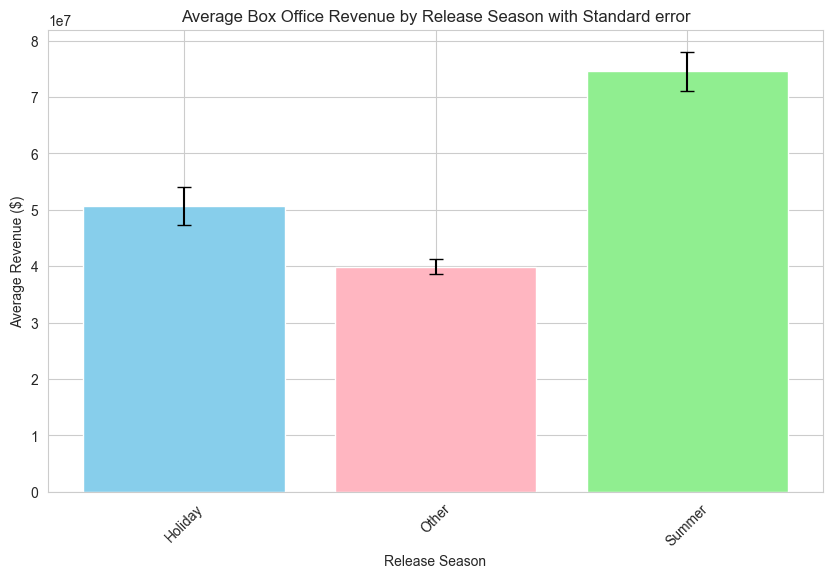

In [59]:
# Apply the function to create a 'release_season' column
df_movies['release_season'] = df_movies['release_month'].apply(data_utils.categorize_release_season)

# Calculate average revenues and standard error for each season
season_stats = df_movies.groupby('release_season')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Release Season:")
print(season_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(season_stats.index, season_stats['mean'], yerr=season_stats['sem'], color=['skyblue', 'lightpink', 'lightgreen'], capsize=5)
plt.title('Average Box Office Revenue by Release Season with Standard error')
plt.xlabel('Release Season')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Release Season

The results indicate the following average revenues:

- **Holiday**: $50.77 million
- **Summer**: $74.58 million
- **Other**: $39.93 million

##### Observations

1. **Higher revenue in summer and holiday seasons**: Movies released during the summer and holiday seasons tend to generate nearly double the revenue of films released during other times. This trend suggests that these peak periods are associated with higher box office performance.

2. **Lower revenue for other seasons**: Films released outside the summer and holiday months have an average revenue of about $39.62 million, noticeably lower than those released during peak seasons.

#### Possible Causes

1. **People have more free time during holidays**: During the summer and holiday breaks, most people work less hours, so having more free time makes them more likely to attend movies.

2. **Studios plan strategic releases**: Studios often schedule their major and highly anticipated films during holidays and summer to capture larger audiences. Actions movies are released more during summer and family-friendly films are commonly released during these holidays when families reunites together.

3. **Marketing Efforts**: Studios usually invest heavily in marketing campaigns leading up to summer and holiday releases, which builds hype. This increased promotion can lead to higher attendance.

5. **Competitive environment to create something better**: Peak seasons bring more competition between studios, most of them invest a lot to create their bests movies because of the expanded audience size during these times, making summer and holiday releases the more profitables of the year. The fact that there is more competition can also be reconized by an high standard error in summer and holiday. More studios take risks to blow up and sometimes their predictions don't go as expected.

### Which genres have the highest average box office revenue?
- Display highest average box office revenue by genre (of the most 20 relevante genres).

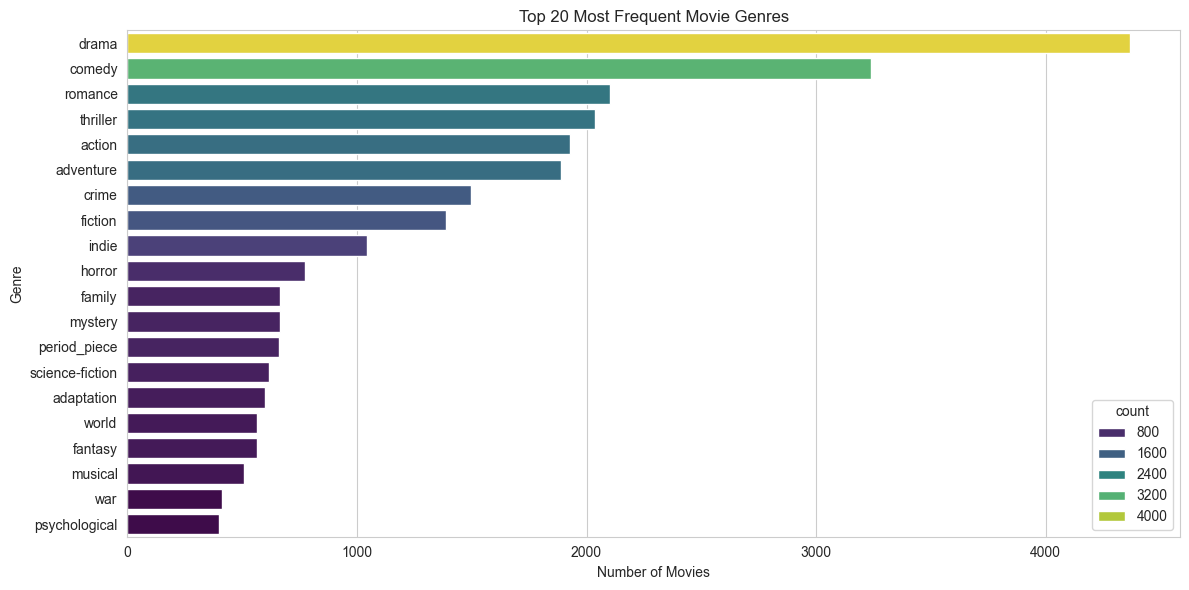

In [60]:
# Count the number of movies in each genre
genre_counts = df_movies['genres'].explode().value_counts()

# Create a dataframe with the genre counts and save the top 20 most frequent genres
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)
top_genres = genre_counts_df.head(20)

# Plot the top 20 most frequent genres
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, y='genre', x='count', hue='count', palette="viridis")
plt.title('Top 20 Most Frequent Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Average Box Office Revenue by Top 20 Genres:
                         mean           sem
genres                                     
fantasy          1.220199e+08  9.585742e+06
science-fiction  1.083780e+08  8.485672e+06
adventure        8.648948e+07  3.982014e+06
action           8.308088e+07  3.830586e+06
family           7.450184e+07  5.376374e+06
thriller         6.853330e+07  2.946463e+06
mystery          5.808759e+07  4.462343e+06
adaptation       5.488355e+07  4.756878e+06
fiction          5.140678e+07  2.953074e+06
war              4.819004e+07  4.535190e+06
crime            4.720055e+07  2.307257e+06
horror           4.680759e+07  3.181837e+06
psychological    4.516403e+07  4.099746e+06
period_piece     4.502928e+07  4.411531e+06
comedy           4.335669e+07  1.511968e+06
romance          4.146475e+07  2.007986e+06
drama            3.928705e+07  1.428636e+06
musical          2.942948e+07  3.170855e+06
world            1.810928e+07  1.649153e+06
indie            1.361580e+07  

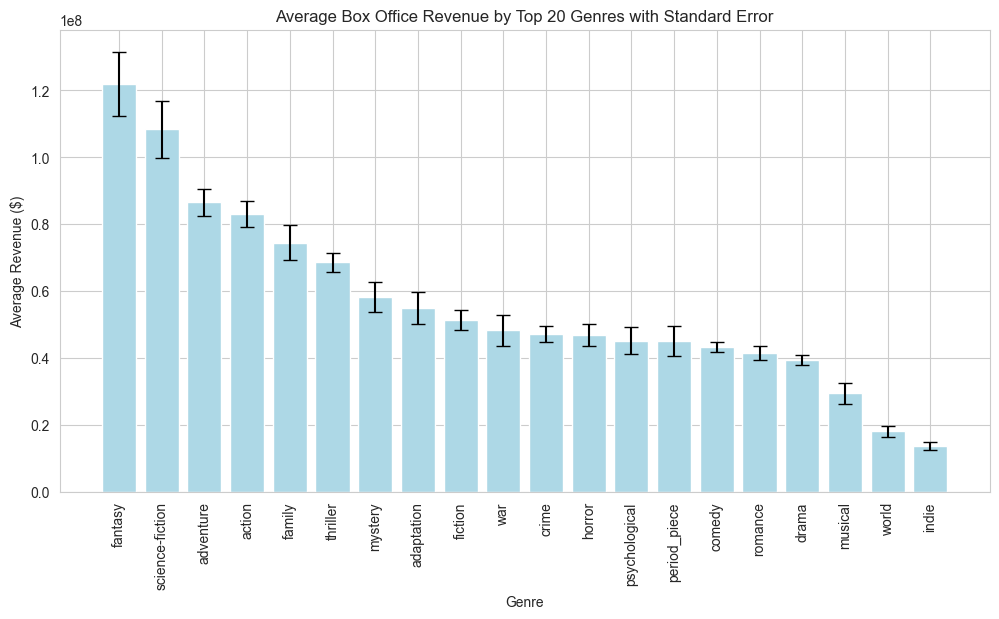

In [61]:
# Calculate average revenue and standard error by genre 
genre_stats = df_movies.explode('genres').groupby('genres')['box_office_revenue'].agg(['mean', 'sem'])

# Filter out the 20 most frequent genres
genre_stats = genre_stats[genre_stats.index.isin(top_genres['genre'])]

# Sort by the highest average revenue
genres_revenue = genre_stats.sort_values(by='mean', ascending=False)

# Print the average revenue by genre
print("Average Box Office Revenue by Top 20 Genres:")
print(genres_revenue)

# Plot the average revenue by genre
plt.figure(figsize=(12, 6))
plt.bar(genres_revenue.index, genres_revenue['mean'], yerr=genres_revenue['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Top 20 Genres with Standard Error')
plt.xlabel('Genre')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=90)
plt.show()

TODO: change!
#### Analysis of Average Box Office Revenue by Genre

The results indicate the following top average revenues by genre:

- **Computer Animation**: $301.54 million
- **Glamorized Spy Film**: $208.46 million
- **Fantasy Adventure**: $181.38 million
- **Superhero**: $179.11 million

##### Observations

1. **Highest revenue for computer animation**: Computer-animated films now lead in average revenue, reaching $301.54 million. These films are watched by both children and adults, allowing for wide demographic appeal and strong family-friendly marketability. Their titles popularity and high-quality visuals effects make them especially attractive for many audiences of different cultueres.

2. **Glamorized spy films and superheroes are popular choices**: With average revenues of $208.46 million and $179.11 million, glamorized spy films and superhero movies maintain high popularity. Their action-packed storylines with iconic characters contribute to high box office earnings, especially in international markets for american movies. Pairing these genres with well-known actors and directors can boost their appeal across diverse audience segments. Superheroes movies also have very low standard error respect to the other genres.

##### Possible Causes

1. **Audience preference for high-production genres**: Genres with high production values, like computer animation and glamorized spy films, typically have larger budgets that allow for impressive visual effects and catch audiences looking for superlative cinematic experiences.

2. **Brand recognition**: Genres with established franchise potential, such as superhero consistently perform well. Brand recognition and affidability makes people fall in love with those movies, contributing to these genres’ high revenue.

5. **Appeal to different generations**: Genres like computer animation and fantasy adventure appeal to various demographic groups, from families to younger audiences. This broad appeal contributes to stronger box office performance, as these genres are accessible to diverse age groups.


### How does film runtime correlate with box office revenue, and do longer or shorter films tend to perform better?
- Analyze revenue by runtime to see if longer or shorter films tend to perform better.


C:\Users\vaffs\AppData\Local\Temp\ipykernel_15508\3982794727.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])


Average Box Office Revenue by Runtime Category:
runtime_category
Short     3.125696e+07
Medium    3.876583e+07
Long      7.823741e+07
Name: mean, dtype: float64

Runtime definitions based on quantiles:
- Short: ≤ 96.0 minutes
- Medium: 97.0-110.0 minutes
- Long: > 111.0 minutes


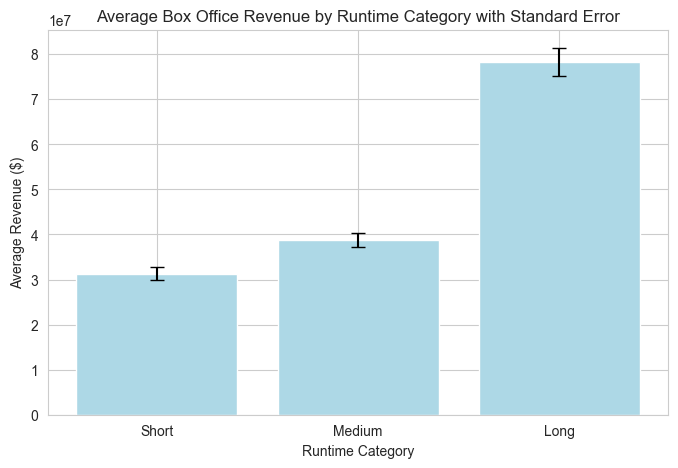

In [62]:
# Define runtime bins based on quantiles for equal-sized groups
df_movies['runtime_category'] = pd.qcut(df_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])

# Verify the approximate runtime boundaries for each category
short_max = df_movies[df_movies['runtime_category'] == "Short"]['runtime'].max()
medium_min = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].min()
medium_max = df_movies[df_movies['runtime_category'] == "Medium"]['runtime'].max()
long_min = df_movies[df_movies['runtime_category'] == "Long"]['runtime'].min()

# Calculate average revenue and sem by runtime category
runtime_stats = df_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenue by runtime category
print("Average Box Office Revenue by Runtime Category:")
print(runtime_stats['mean'])
print(f"\nRuntime definitions based on quantiles:\n- Short: ≤ {short_max} minutes\n- Medium: {medium_min}-{medium_max} minutes\n- Long: > {long_min} minutes")

# Plot the average revenue by runtime category
plt.figure(figsize=(8, 5))
plt.bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
plt.title('Average Box Office Revenue by Runtime Category with Standard Error')
plt.xlabel('Runtime Category')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=0)
plt.show()

# Calculate pearson correlation
# df_movies_after_80s = df_movies[df_movies['release_year'] > 1980]
# print(f"Pearson correlation between release year and runtime: {stats.pearsonr(df_movies_after_80s['box_office_revenue'], df_movies_after_80s['runtime'])}")

#### Analysis of Average Box Office Revenue by Film Runtime

The runtime categories, divided into equal-sized groups based on quantiles, are defined as follows:

- **Short Films**: Runtime of 96 minutes or less
- **Medium Films**: Runtime between 97 and 110 minutes
- **Long Films**: Runtime greater than 111 minutes

The average box office revenues based on these runtime categories are as follows:

- **Short Films**: $31.26 million
- **Medium Films**: $38.77 million
- **Long Films**: $78.21 million

##### Observations
Observation are back by the Pearson's correlation coefficient whihc indicates a small (0.20) but significant (p < 0.05) correlation between runtime and revenue. Basically, longer films would mean larger revenue. But in order to be more accurate, we consider films made after the 80s since before, films were obviously shorter and performing less. 

1. **Significantly higher revenue for longer films**: Films with a runtime over 111 minutes ("Long") have a considerably higher average revenue, nearly double that of medium-length films and more than double that of short films. This suggests that audiences may be more inclined to invest in longer, more immersive film experiences.

3. **Lower revenue for short films**: Films with runtimes of 96 minutes or less ("Short") yield the lowest average revenue, which may suggest a limited appeal.

##### Possible Causes

1. **More storytelling in long films**: Longer runtimes allow for more complex plot development and character development, which can be particularly engaging, potentially leading to higher audience satisfaction and ticket sales, i.e. revenues.

2. **Higher production value and ticket prices**: Longer films may often have larger production budgets, which can contribute to high-quality visuals, effects, and top-tier cast members. These elements often appeal to audiences and justify higher ticket prices.

4. **Audience willingness to watch longer movies**: Longer films may attract dedicated audiences who value a full and long cinematic experience, while shorter films may appeal more to casual viewers, resulting in lower average box office revenue.

### Which 10 languages have the highest average box office revenue?
- Display highest 10 average box office revenue by language.

In [63]:
# Convert the 'languages' dictionary to a list of language for each movie
df_movies['all_languages'] = df_movies['languages'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])

# Explode the 'all_languages' list so that each language has its own row
df_languages = df_movies.explode('all_languages')

# Count movies by language
language_counts = df_languages['all_languages'].value_counts()
print("Number of Movies by language:")
print(language_counts)

Number of Movies by language:
all_languages
English Language                 7387
French Language                   534
Spanish Language                  427
German Language                   266
Korean Language                   251
                                 ... 
Korean Sign Language                1
Kinyarwanda language                1
Luxembourgish language              1
Napoletano-Calabrese Language       1
Standard Tibetan                    1
Name: count, Length: 143, dtype: int64


Average Box Office Revenue by Top 10 Languages:
                             mean           sem  count
all_languages                                         
Latin Language       1.390445e+08  2.685478e+07     49
Portuguese Language  1.193924e+08  2.735045e+07     45
Russian Language     1.115866e+08  1.704854e+07    186
Arabic Language      1.045101e+08  1.536502e+07     81
Hebrew Language      1.011653e+08  2.350782e+07     46
Spanish Language     9.008994e+07  9.549400e+06    427
Italian Language     8.977924e+07  1.228346e+07    239
Standard Mandarin    8.741543e+07  1.366029e+07    117
German Language      8.657641e+07  1.077494e+07    266
French Language      8.292300e+07  7.269103e+06    534


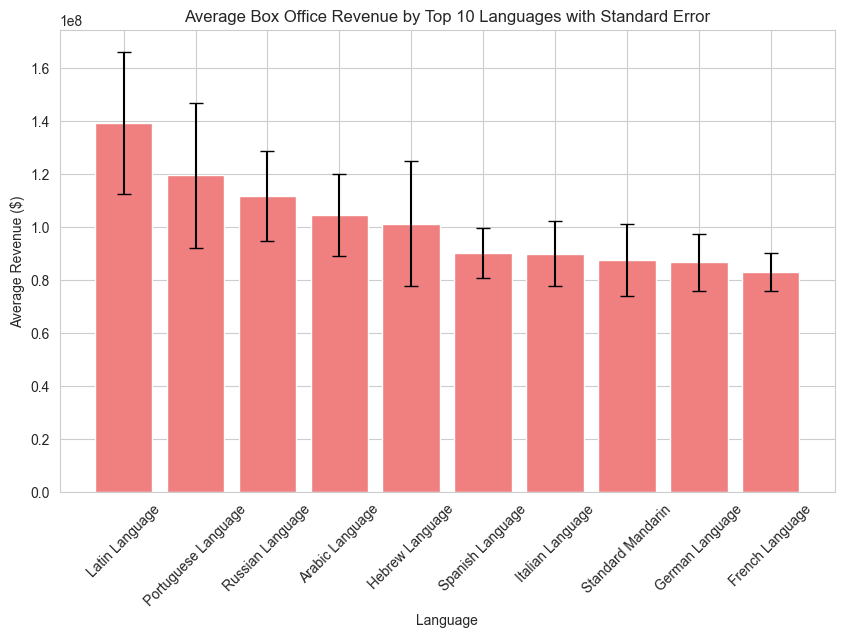

In [64]:
# Calculate average revenue, standard error and count by primary language
language_stats = df_languages.groupby('all_languages')['box_office_revenue'].agg(['mean', 'sem', 'count'])

# We filter out the statistically irrelevant languages
language_stats = language_stats[language_stats['count'] >= 30]

# Select the top 10 languages with the highest average revenue
top_10_languages = language_stats.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by language
print("Average Box Office Revenue by Top 10 Languages:")
print(top_10_languages)

# Plot the average revenue by language
plt.figure(figsize=(10, 6))
plt.bar(top_10_languages.index, top_10_languages['mean'], yerr=top_10_languages['sem'], color='lightcoral', capsize=5)
plt.title('Average Box Office Revenue by Top 10 Languages with Standard Error')
plt.xlabel('Language')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

#### Analysis of Average Box Office Revenue by Language

The average box office revenues based on the primary language of the films are as follows:

- **Latin Language**: $139.04 million
- **Portuguese Language**: $119.39 million
- **Russian Language**: $112.17 million
- **Arabic Language**: $104.51 million
- **Hebrew Language**: $101.17 million
- **Spanish Language**: $90.26 million
- **Italian Language**: $89.78 million
- **Standard Mandarin**: $87.88 million
- **German Language**: $86.58 million
- **French Language**: $82.92 million

##### Observations

1. **High revenue for latin and portuguese movies**: Latin and Portuguese language films lead in average box office revenue, with $139.04 million and $119.39 million respectively. This suggests that the audience is very various, possibly fueled by the world cultural significance of films produced in these languages. Noticeably portuguese movies have a high standard error compared to the other languages, this means that the revenue predictions for portuguese movies could not be very accurate.

2. **Strong performance of russian and arabic films**: Russian and Arabic language films also show high average revenues, at over $100 million each, likely benefiting from the significant number of speakers worldwide especially arabic.

3. **Broad appeal of spanish and italian movies**: Spanish and Italian language films maintain strong positions with substantial average revenues, likely benefiting from their famous artistic culture and global popularity of films in these languages.

4. **Consistent success across major european languages**: Languages like French, German, and Italian continue to perform well, highlighting the broad European and global appeal of films in these languages, likely driven by diverse themes and robust cinematic traditions.

##### Possible Causes

1. **Cultural resonance and international appeal**: Films in languages such as Latin, Italian, Portuguese, and Spanish may have better results with international audiences, who are drawn to culturally rich narratives and the broad linguistic appeal of these languages.

2. **Large domestic audiences**: Languages with substantial domestic communities, such as Russian and Arabic, can attract a huge part of the locals who connect with these films' cultural themes.

3. **Cinematic traditions**: European languages like French and Italian benefit from strong cinematic traditions, with films that appeal across multiple countries and cultural contexts.

### Which 10 actors have the highest average box office revenue?

In [65]:
# Count the number of movies for each actor
actors_count = df_actors_revenues['actor_name'].value_counts()
actors_count = actors_count[actors_count >= 20]

# Keep only actors with at least 20 movies
relevant_characters = df_actors_revenues[df_actors_revenues['actor_name'].isin(actors_count.index)]

# calculate the average revenue for each actor
actors_revenues = relevant_characters.groupby('actor_name')['box_office_revenue'].mean()

# Create a dataframe with the average revenue and number of movies for each actor
df_actors_info = pd.DataFrame({
    'mean_revenue': actors_revenues,
    'n_movies': actors_count
})

# Print the top 10 actors by average revenue
print("Top 10 Actors by Average Box Office Revenue:")
df_actors_info.sort_values(by='mean_revenue', ascending=False).head(10)

Top 10 Actors by Average Box Office Revenue:


,mean_revenue,n_movies
actor_name,,
Hugo Weaving,3.706721e+08,24
Alan Rickman,3.520243e+08,29
Robbie Coltrane,3.364884e+08,30
Maggie Smith,3.200121e+08,29
John Rhys-Davies,3.135264e+08,20
Richard Griffiths,3.086754e+08,21
Will Smith,3.083475e+08,20
Helena Bonham Carter,3.022026e+08,26
Christopher Lee,2.943084e+08,25


#### Analysis of Average Box Office Revenue by Actor

The average box office revenues based on the primary actors in the films are as follows:

- **Hugo Weaving**: $370.67 million
- **Alan Rickman**: $352.02 million
- **Robbie Coltrane**: $336.49 million
- **Maggie Smith**: $320.01 million
- **John Rhys-Davies**: $313.53 million
- **Richard Griffiths**: $308.68 million
- **Will Smith**: $308.35 million
- **Helena Bonham Carter**: $302.20 million
- **Christopher Lee**: $294.31 million
- **Timothy Spall**: $293.07 million

##### Observations

1. **Top performers with strong box office returns**: Actors like **Hugo Weaving**, **Alan Rickman**, and **Robbie Coltrane** lead in average box office revenue, all exceeding $330 million. This can be attributed to their roles in highly successful franchises such as *The Lord of the Rings* and *Harry Potter*, where their performances were central to the films' broad global appeal.

2. **Strong performances by veteran actors**: Many of the top actors, including **Maggie Smith**, **John Rhys-Davies**, and **Richard Griffiths**, have strong box office returns, likely due to their consistent roles in large franchises, particularly within the fantasy and adventure genres. Their longevity in the industry has allowed them to be part of major cinematic events that consistently draw large audiences.

##### Possible Causes

1. **Important titles bring high revenues**: Actors associated with successful franchises, such as the *Harry Potter* and *The Lord of the Rings* series, tend to have higher average box office revenues due to the repeated success of these films and their lasting popularity with audiences.

2. **Broad international reach**: Actors like **Will Smith** have the advantage of global appeal, often present in american movies that have a broad international reach.

3. **Veteran status**: Many of these actors have been in the industry for decades, which allows them to participate in high-budget films with significant box office potential. Their established reputations and fan loyalty contribute to their sustained success.

### What is the average box office revenue by actors age group?

Average Box Office Revenue by Actors Age:
                         mean  count           sem
actor_age_group                                   
child            1.004381e+08   1951  3.905874e+06
teen             8.886942e+07   2215  3.827905e+06
young_adult      6.593306e+07  30169  8.116483e+05
adult            7.764041e+07  41313  7.700614e+05
senior           5.618594e+07  25205  8.205176e+05


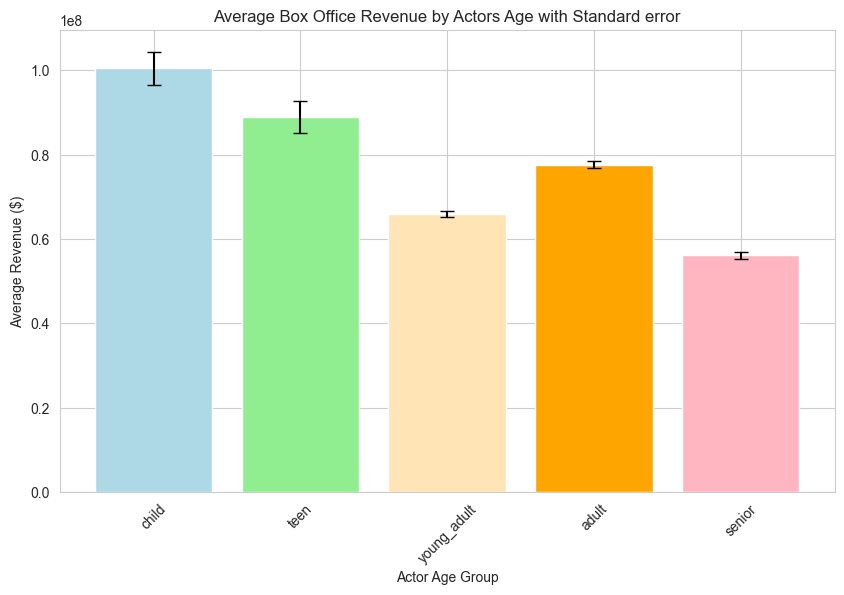

In [66]:
# Create a new column with the age group of the actors
df_actors_revenues['actor_age_group'] = df_actors_revenues['actor_age'].apply(data_utils.categorize_age_group)

# Calculate average revenues and standard error for each age group
age_stats = df_actors_revenues.groupby('actor_age_group')['box_office_revenue'].agg(['mean', 'count', 'sem'])
# Order the age groups
age_stats = age_stats.loc[['child', 'teen', 'young_adult', 'adult', 'senior']]

# Print the average revenues by age group
print("Average Box Office Revenue by Actors Age:")
print(age_stats)

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(age_stats.index, age_stats['mean'], yerr=age_stats['sem'], color=['lightblue', 'lightgreen', 'moccasin', 'orange', 'lightpink'], capsize=5)
plt.title('Average Box Office Revenue by Actors Age with Standard error')
plt.xlabel('Actor Age Group')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

### Does the gender distribution of actors in a film influence its average box office revenue?

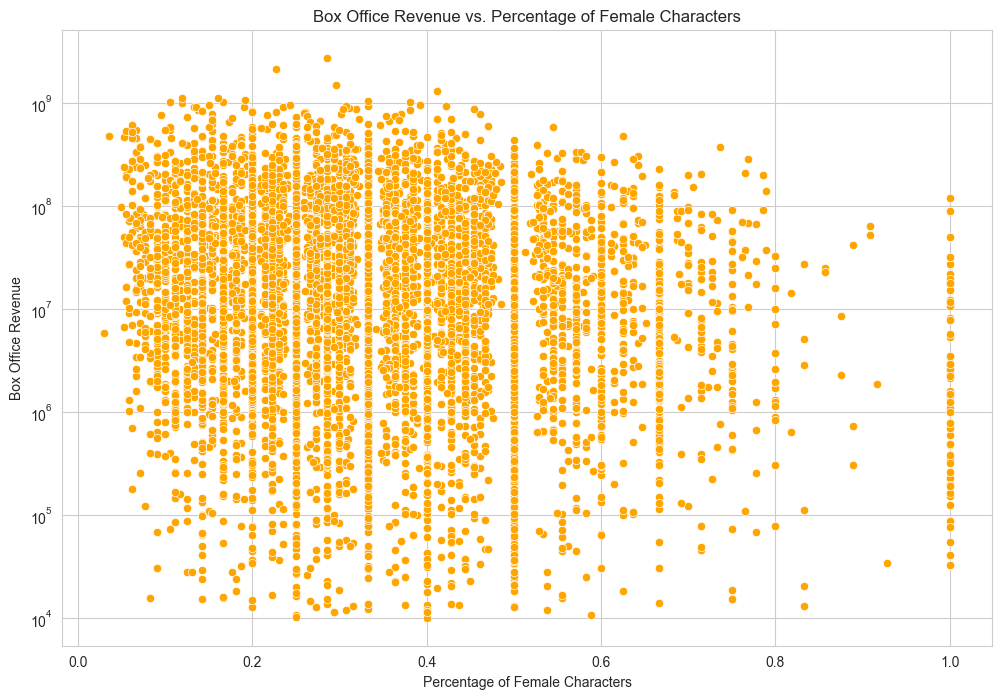

In [67]:
# Box office revenue based on the gender of the actors? 
movies_gender_distribution = df_actors_revenues.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_gender'].value_counts(normalize=True).unstack().reset_index()
movies_gender_distribution = movies_gender_distribution.rename(columns={'F': 'Female', 'M': 'Male'})

plt.figure(figsize=(12, 8))
sns.scatterplot(data=movies_gender_distribution, x='Female', y='box_office_revenue', color='orange')
plt.xlabel('Percentage of Female Characters')
plt.ylabel('Box Office Revenue')
plt.yscale('log')
plt.title('Box Office Revenue vs. Percentage of Female Characters')
plt.show()

### What is the average box office revenue based on the gender predominance in the movie cast?

Average Box Office Revenue by Actors Gender Dominance:
predominant_gender
Balanced    2.329114e+07
Female      3.183796e+07
Male        5.438580e+07
Name: mean, dtype: float64


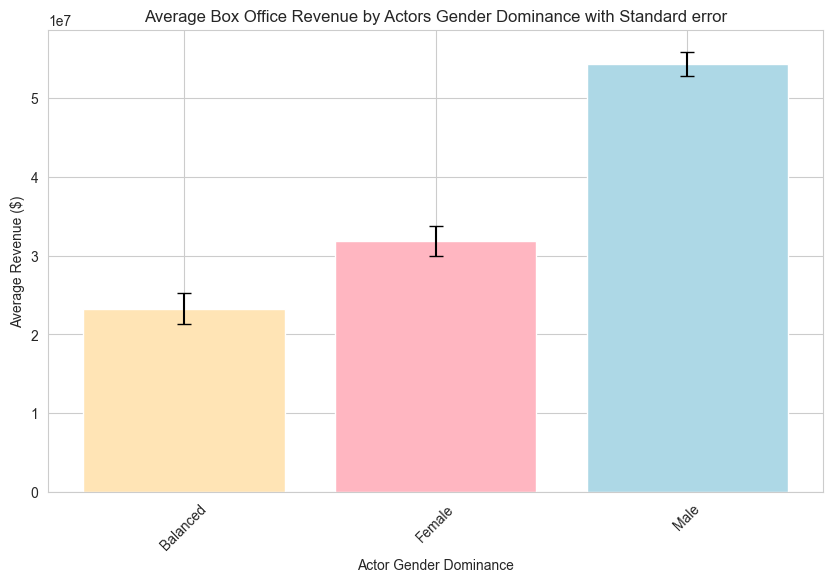

In [68]:
movies_gender_distribution['predominant_gender'] = movies_gender_distribution.apply(
    lambda row: 'Balanced' if row['Male'] == row['Female'] else row[['Male', 'Female']].idxmax(), axis=1
)
gender_stats = movies_gender_distribution.groupby('predominant_gender')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenues by season
print("Average Box Office Revenue by Actors Gender Dominance:")
print(gender_stats['mean'])

# Plot the average revenues with standard error bars
plt.figure(figsize=(10, 6))
plt.bar(gender_stats.index, gender_stats['mean'], yerr=gender_stats['sem'], color=['moccasin', 'lightpink', 'lightblue'], capsize=5)
plt.title('Average Box Office Revenue by Actors Gender Dominance with Standard error')
plt.xlabel('Actor Gender Dominance')
plt.ylabel('Average Revenue ($)')
plt.xticks(rotation=45)
plt.show()

### What is the average box office revenue based on the ethnic diversity in the movie cast?

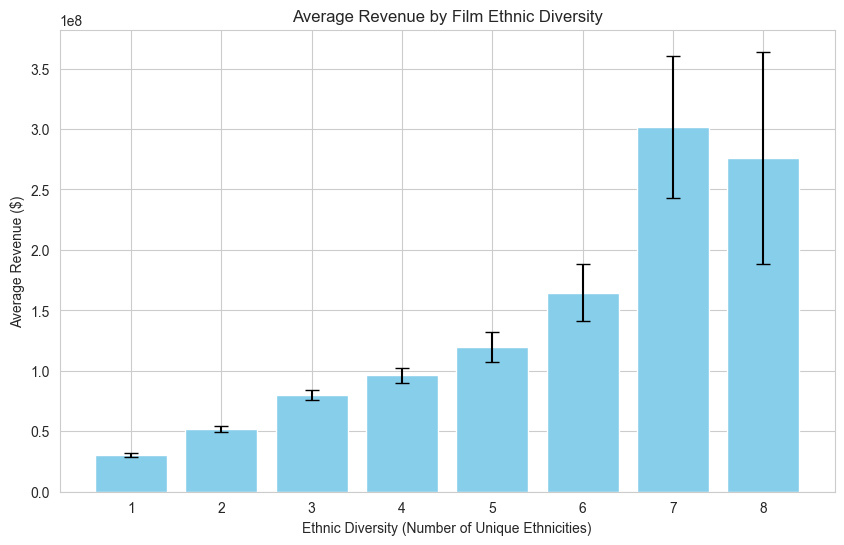

In [69]:
# Explode the 'actor_ethnicity' (an actor can have several ethnicities)
df_exploded = df_actors_revenues.explode('actor_ethnicity')

# Keep only the ethnicities with more than 50 actors
ethnicity_count = df_exploded.groupby('actor_ethnicity')['actor_name'].nunique().reset_index()
ethnicity_count.columns = ['actor_ethnicity', 'num_atores']

relevant_ethnicities = ethnicity_count[ethnicity_count['num_atores'] > 50]
df_filtered = df_exploded[df_exploded['actor_ethnicity'].isin(relevant_ethnicities['actor_ethnicity'])]

# Calculate the diversity for each movie
diversity_per_movie = df_filtered.groupby(['wikipedia_movie_id', 'box_office_revenue'])['actor_ethnicity'].nunique().reset_index()
diversity_per_movie.columns = ['wikipedia_movie_id', 'box_office_revenue', 'diversity']

revenue_per_diversity = diversity_per_movie.groupby('diversity')['box_office_revenue'].agg(['mean', 'sem'])

# Print the average revenue by diversity
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_diversity.index, revenue_per_diversity['mean'], yerr=revenue_per_diversity['sem'], color='skyblue', capsize=5)
plt.xticks(revenue_per_diversity.index)
plt.xlabel('Ethnic Diversity (Number of Unique Ethnicities)')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Film Ethnic Diversity')
plt.show()

### Which 10 ethnicities have the highest average box office revenue?

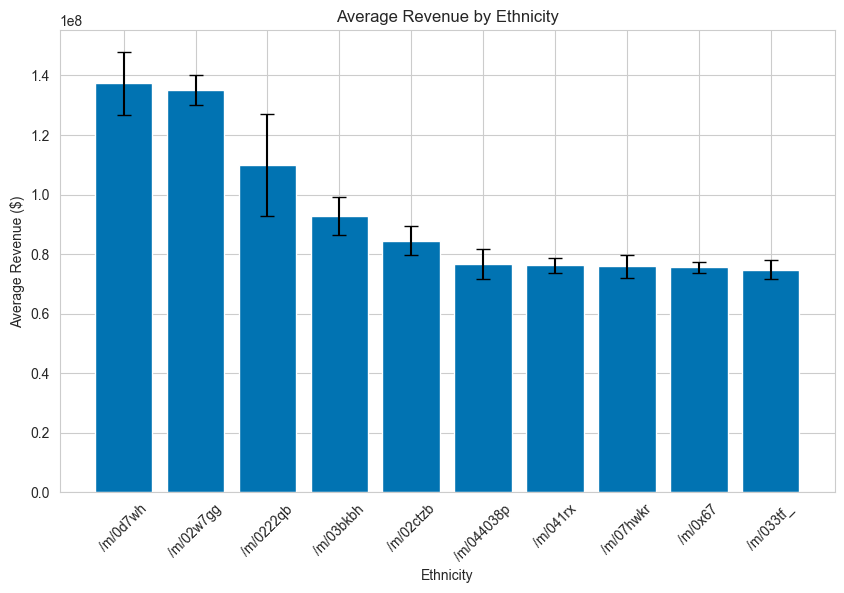

In [70]:
# Calculate the average revenue by ethnicity 
revenue_per_ethnicity = df_filtered.groupby('actor_ethnicity')['box_office_revenue'].agg(['mean', 'sem'])
revenue_per_ethnicity = revenue_per_ethnicity.sort_values(by='mean', ascending=False).head(10)

# Print the average revenue by ethnicity
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_ethnicity.index, revenue_per_ethnicity['mean'], yerr=revenue_per_ethnicity['sem'], capsize=5)
plt.xlabel('Ethnicity')
plt.ylabel('Average Revenue ($)')
plt.title('Average Revenue by Ethnicity')
plt.xticks(rotation=45)
plt.show()

### Do some countries combine better with a specific genre ?

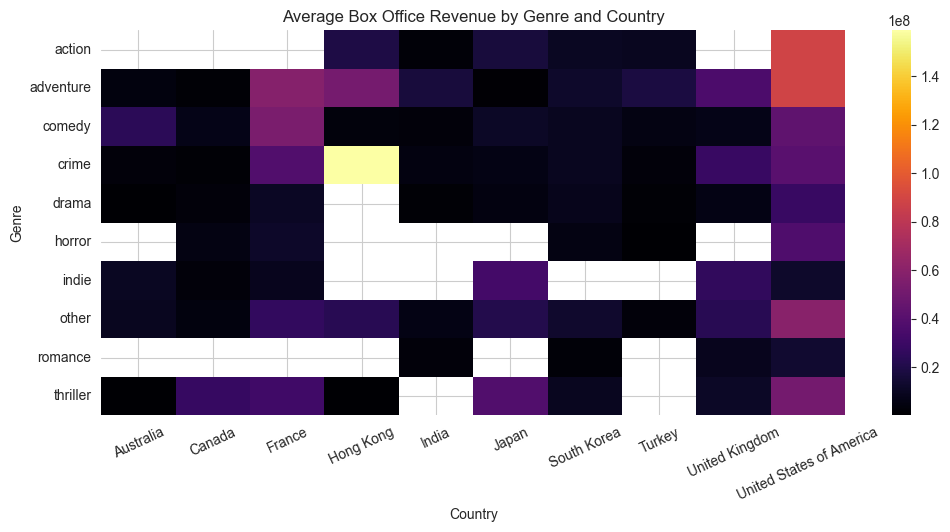

In [71]:
# plot a heatmap of genres and countries to revenue
df_genres_countries = df_movies[['genres', 'countries', 'box_office_revenue']].copy()

df_genres_countries['all_countries'] = df_genres_countries['countries'].apply(lambda x: list(x.values()) if isinstance(x, dict) else [])
df_genres_countries['main_country'] = df_genres_countries['all_countries'].apply(lambda x: x[0] if x else None)

# keep only the top 10 countries
top_10_countries = df_genres_countries['main_country'].value_counts().head(10).index
df_genres_countries = df_genres_countries[df_genres_countries['main_country'].isin(top_10_countries)]

df_genres_countries['genres'] = df_genres_countries['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'other')
df_genres_countries['main_genre'] = df_genres_countries['genres'].apply(lambda x: x if x in top_genres['genre'].head(10).tolist() else 'other')


# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df_genres_countries.pivot_table(index='main_genre', columns='main_country', values='box_office_revenue', aggfunc='mean'), cmap='inferno')
plt.title('Average Box Office Revenue by Genre and Country')
plt.xlabel('Country')
plt.xticks(rotation=25)
plt.ylabel('Genre')
plt.show()


#### Analysis TODO: review

Again ! there are some combinations that are smarter than others. Romance movies in France, who would have thought ? US and adventure movies seem to be a winning combination as well. This trend highlights the popularity of adventure films in the US market, likely due to their broad appeal and engaging. It seems that horror movies in Canada tend to perform exceptionally well.

### Is there a linear relation between the mean actor's age and the revenue ?

# When i tried to run this it didn't finish even in 30 minutes, someone else please confirm

In [ ]:
import statsmodels.formula.api as smf

## TODO - check if this is correct/interesting 

df_mean_actor_age = df_actors_revenues.groupby('wikipedia_movie_id').agg({'actor_age': 'mean', 'box_office_revenue': 'mean'}).reset_index()

mod = smf.ols(formula='box_office_revenue ~ actor_age', data=df_mean_actor_age)
np.random.seed(2)
res = mod.fit()
print(res.summary())

### How have these features have evolved over time ?

We discovered some trends during the EDA analysis but to give an accurate advice to film producers, we need to understand if trends are coming, leaving or have always been there. Therefore, analyse how it has changed overtime will give us a good understanding on that.

#### Box office revenue through the years

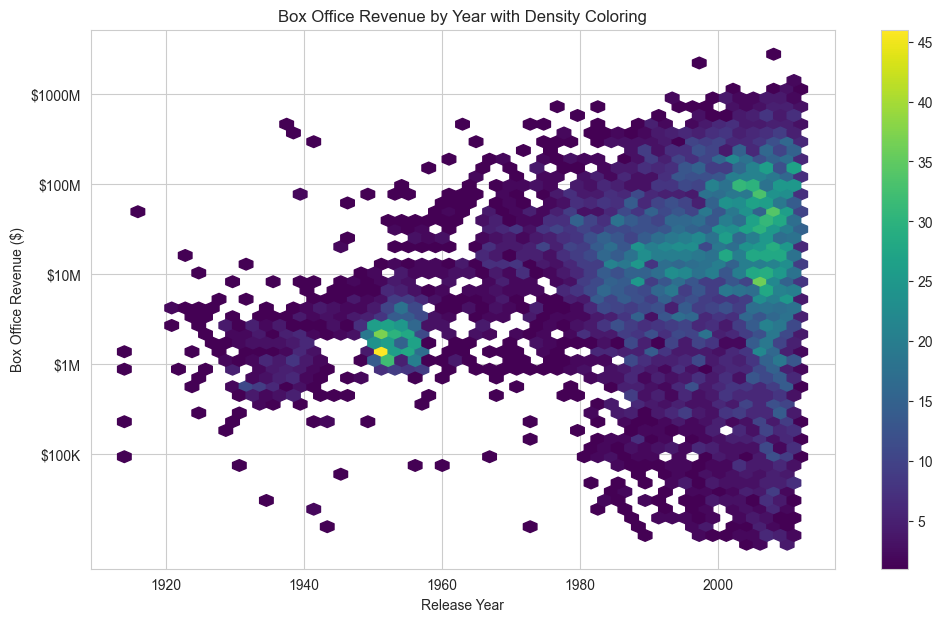

In [73]:
# Plot the box office revenue for each film over the years
plt.figure(figsize=(12, 7))

plt.hexbin(df_movies['release_year'], np.log(df_movies['box_office_revenue']), gridsize=50, cmap='viridis', mincnt=1)
#plt.yscale('log') #for some reasons this isn't working, so we aplied the log directly
custom_ticks = np.log1p([1e5, 1e6, 1e7, 1e8, 1e9])  
custom_labels = ['$100K', '$1M', '$10M', '$100M', '$1000M']  
plt.yticks(custom_ticks, custom_labels)
plt.colorbar()
plt.xlabel('Release Year')
plt.ylabel('Box Office Revenue ($)')
plt.title('Box Office Revenue by Year with Density Coloring')
plt.show()



# Calculate pearson correlation
#print(f"Pearson correlation between release year and box office revenue: {stats.pearsonr(df_movies['release_year'], df_movies['box_office_revenue'])}")


##### Analysis

It is nice to see that the industry is not dying ! At first glance, we see of course more movies and thus the revenue is more diverse. But thanks to the mean and the Pearson correlation coefficient along the the pvalue, we can be sure that there is a small (0.18) but significant (p < 0.05) correlation between time and revenue.

Moreover, we can see that the revenue distribution is more and more spread through the decades. This means that it is possible for some movies to perform really well and enforece the idea that it is interesting to look at the factors that are allowing these results.

#### Average revenue for top genres through the years

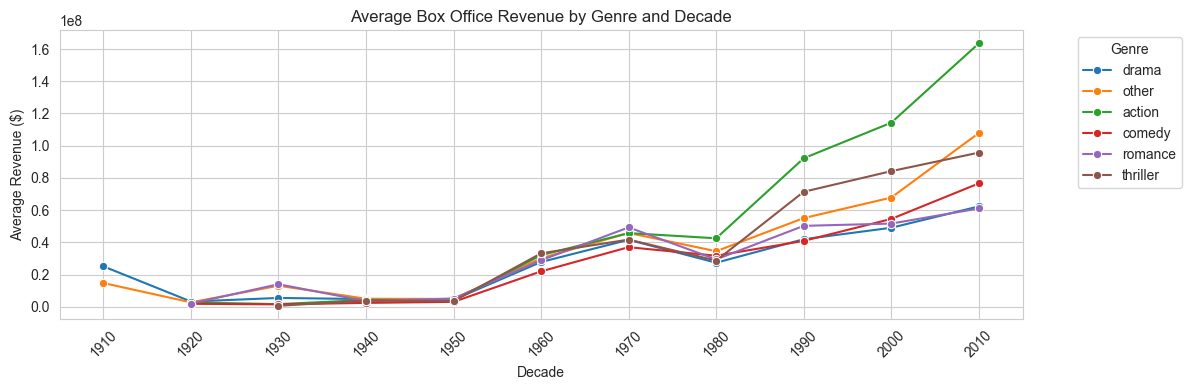

In [74]:
# Extract features
df_movies_genres = df_movies.explode('genres').copy()
df_movies_genres.dropna(subset=['genres'], inplace=True)
df_movies_genres['genre'] = df_movies_genres['genres'].apply(lambda x: x if x in top_genres['genre'].head(5).tolist() else 'other')
df_movies_genres['release_decade'] = df_movies_genres['release_year'] // 10 * 10

genre_decade_stats = df_movies_genres.groupby(['release_decade', 'genre'])['box_office_revenue'].agg(['mean', 'count', 'sem'])
genre_decade_stats.sort_values(by='release_decade', inplace=True)

# Plot
plt.figure(figsize=(12, 4))
sns.lineplot(data=genre_decade_stats.reset_index(), x='release_decade', y='mean', hue='genre', marker='o', palette='tab10')
plt.title('Average Box Office Revenue by Genre and Decade')
plt.xlabel('Decade')
plt.ylabel('Average Revenue ($)')
plt.xticks(np.arange(min(genre_decade_stats.index.get_level_values(0)), max(genre_decade_stats.index.get_level_values(0))+1, 10), rotation=45)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Analysis

Interesting ! There is indeed some genre that are getting more and more popular in the last decades, mayber producers should focus on those ones ?

#### Average runtime through the year

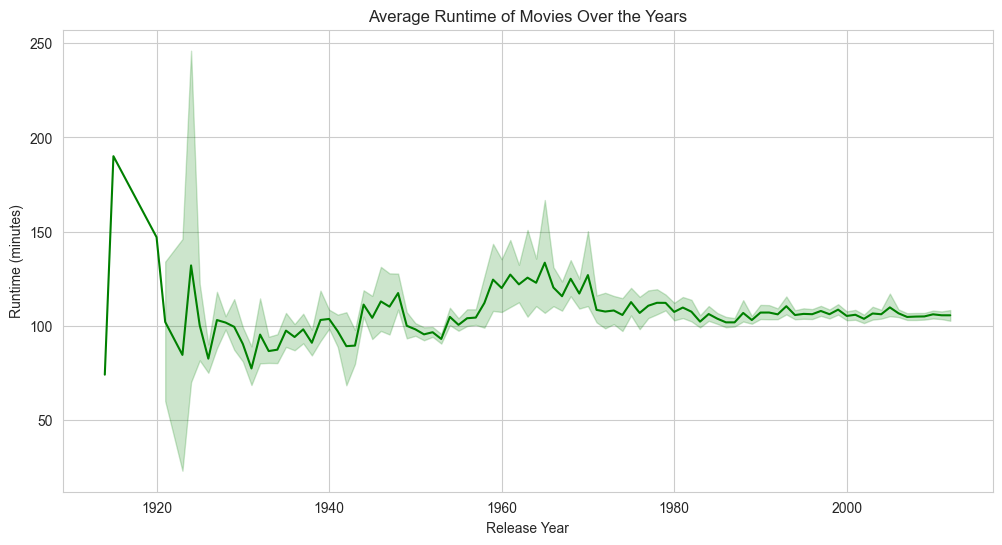

In [75]:
# TODO why it giving different results?
# plot the average runtime through the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_movies, x='release_year', y='runtime', color='green')
plt.title('Average Runtime of Movies Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Runtime (minutes)')
plt.show()


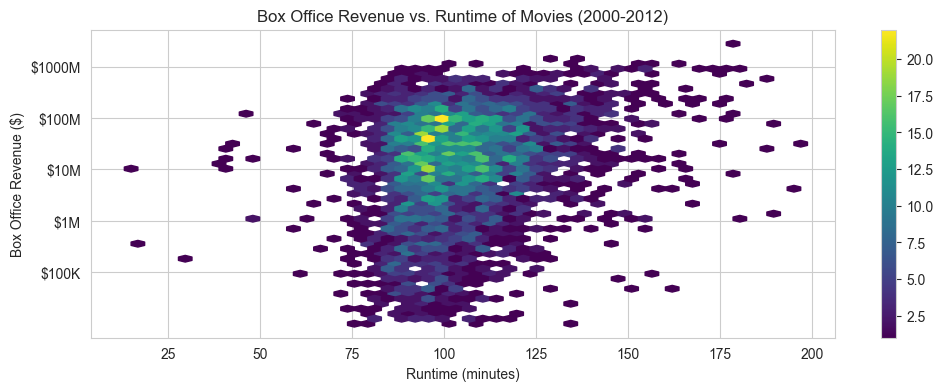

In [76]:
# focus on the new millenium and scatter plot runtime vs revenue
df_movies_after_2000 = df_movies[df_movies['release_year'] >= 2000]
df_movies_after_2000 = df_movies_after_2000[df_movies_after_2000['runtime'] <= 200]

plt.figure(figsize=(12, 4))
plt.hexbin(df_movies_after_2000['runtime'], np.log(df_movies_after_2000['box_office_revenue']),gridsize=50, cmap='viridis', mincnt=1)
plt.title('Box Office Revenue vs. Runtime of Movies (2000-2012)')
plt.colorbar()
custom_ticks = np.log1p([1e5, 1e6, 1e7, 1e8, 1e9])  
custom_labels = ['$100K', '$1M', '$10M', '$100M', '$1000M']  
plt.yticks(custom_ticks, custom_labels)
plt.xlabel('Runtime (minutes)')
plt.ylabel('Box Office Revenue ($)')
plt.show()

# calculate the pearson correlation
#print(f"Pearson correlation between runtime and box office revenue: {stats.pearsonr(df_movies_after_2000['runtime'], df_movies_after_2000['box_office_revenue'])}")


##### Analysis

The average runtime has fluctuated a lot but seems to stabilize since the 90s. Moreover, we can see that the confidence interval narrows as weel which indicate than movie's runtime tend to uniformize. It settles aroun d 105 minutes.

The second plot focuses on the past 2 decades for a more fine-grained analysis. It aims to understand the trend of the last 20 years. As we can both see in the graph and with the pearson correlation coefficient, it seems that we have a small but significant positive correlation between runtime and revenue in the last 20 years.

C:\Users\vaffs\AppData\Local\Temp\ipykernel_15508\3883512720.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_movies['runtime_category'] = pd.qcut(period_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])
C:\Users\vaffs\AppData\Local\Temp\ipykernel_15508\3883512720.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_stats = period_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])
C:\Users\vaffs\AppData\Local\Temp\ipykernel_15508\3883512720.py:21: SettingWithCopyWarning: 
A value is trying to be set on 

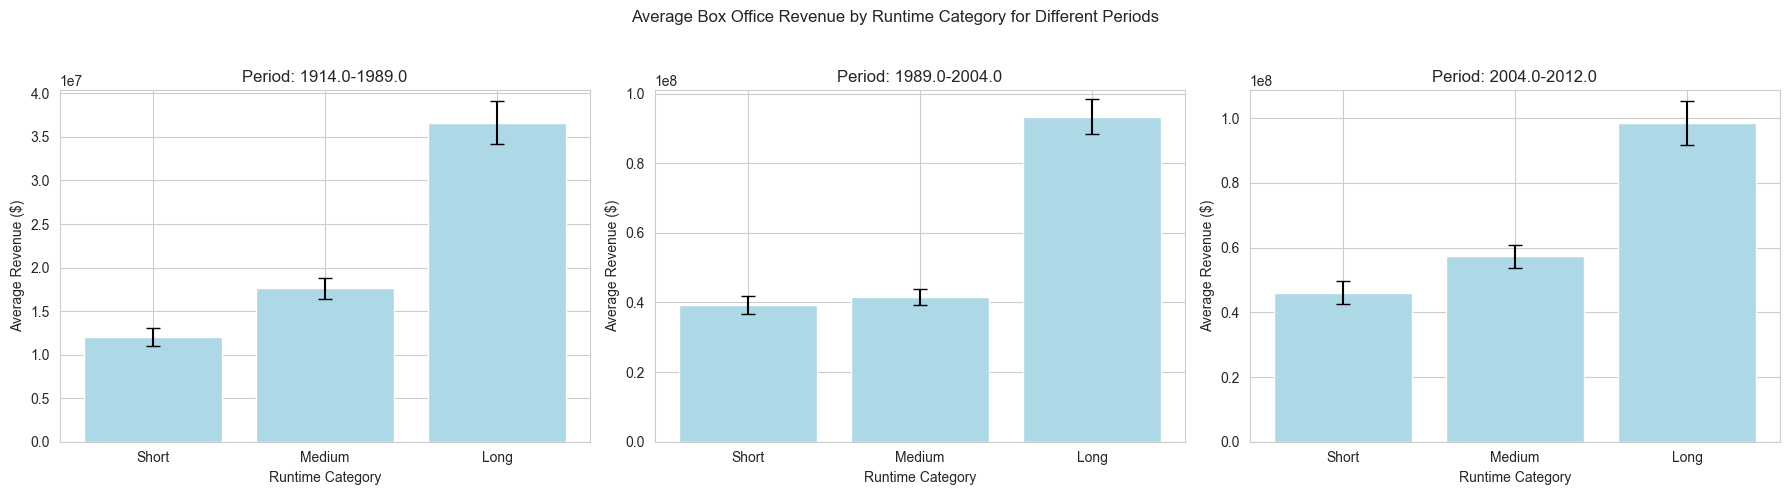

In [77]:
# Sort and divide movies in 3 different periods containing the same number of movies
df_movies_sorted = df_movies.sort_values('release_year').reset_index(drop=True)
total_movies = len(df_movies_sorted)
group_size = total_movies // 3
boundaries = [0, group_size, 2 * group_size, total_movies]
time_periods = [
    (df_movies_sorted.loc[boundaries[i], 'release_year'], 
     df_movies_sorted.loc[boundaries[i + 1] - 1, 'release_year']) 
    for i in range(3)
]

# Create subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Average Box Office Revenue by Runtime Category for Different Periods')

# Iterate over each period and process runtime category
for i, (start_year, end_year) in enumerate(time_periods):
    period_movies = df_movies[(df_movies['release_year'] >= start_year) & (df_movies['release_year'] <= end_year)]

    # Define runtime categories based on quantiles for same sized groups within the period
    period_movies['runtime_category'] = pd.qcut(period_movies['runtime'], q=3, labels=["Short", "Medium", "Long"])
    runtime_stats = period_movies.groupby('runtime_category')['box_office_revenue'].agg(['mean', 'sem'])

    # Plot for the period
    axes[i].bar(runtime_stats.index, runtime_stats['mean'], yerr=runtime_stats['sem'], color='lightblue', capsize=5)
    axes[i].set_title(f'Period: {start_year}-{end_year}')
    axes[i].set_xlabel('Runtime Category')
    axes[i].set_ylabel('Average Revenue ($)')
    axes[i].set_ylim(0, runtime_stats['mean'].max() + runtime_stats['sem'].max() * 1.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Analysis

It can be seen that since 1914 (first movie by release data of our dataset) long movies performed better for revenues. It can also be noticed that the plots of the period 1914-1989 and the period 2004-2012 have almost identical trend, the standard errors and the difference between the three runtime categories has the same height. It can be concluded that long movies generated higher revenues, while short and medium movies generated slightly more than half revenues respect to the long movies. 

## Part 4 : Create a predictive model for box office success

############################################################################# For now i tested 2 classification models and 2 regression models, I think i'm going to try svm #############################################################################

In [78]:
# import the models
import src.models.custom_logistic_regression as custom_logistic_regression
import src.models.logistic_regression as logistic_regression
import src.models.gradient_boosting_regressor as gradient_boosting_regressor
import src.models.random_forest_regression as random_forest_regression

# import the splitting library
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv('data/preprocessed/preprocessed_data.csv') 
X = df.drop(columns=['box_office_revenue']) 
y = df['box_office_revenue']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'data/preprocessed/preprocessed_data.csv'

In [ ]:
# Custom Logistic Regression
custom_lr = custom_logistic_regression.CustomLogisticRegression()
custom_lr.fit(y_train, X_train, y_val, X_val)
custom_lr_results = custom_lr.evaluate(y_val, np.c_[np.ones((X_val.shape[0], 1)), X_val])
print("Custom Logistic Regression Results:", custom_lr_results)

# Logistic Regression
sklearn_lr = logistic_regression.SklearnLogisticRegression()
sklearn_lr.train(X_train, y_train)
sklearn_lr_results = sklearn_lr.evaluate(y_val, X_val)
print("Sklearn Logistic Regression Results:", sklearn_lr_results)

In [ ]:
# Random Forest Regressor
rf_model = random_forest_regression.RandomForestModel()
rf_model.train(X_train, y_train)
rf_results = rf_model.evaluate(X_val, y_val)
print("Random Forest Regressor Results:", rf_results)

# Gradient Boosting Regressor
gb_model = gradient_boosting_regressor.GradientBoostingRegressorModel()
gb_model.train(X_train, y_train)
gb_results = gb_model.evaluate(X_val, y_val)
print("Gradient Boosting Regressor Results:", gb_results)

In [ ]:
# Collect results from models
results_summary = pd.DataFrame({
    "Model": ["Custom Logistic Regression", "Sklearn Logistic Regression", "Random Forest Regressor", "Gradient Boosting Regressor"],
    "MAE": [None, None, rf_results["MAE"], gb_results["MAE"]],
    "MSE": [None, None, rf_results["MSE"], gb_results["MSE"]],
    "RMSE": [None, None, rf_results["RMSE"], gb_results["RMSE"]],
    "Precision": [custom_lr_results["Precision"], sklearn_lr_results["Precision"], None, None],
    "Recall": [custom_lr_results["Recall"], sklearn_lr_results["Recall"], None, None],
    "F1 Score": [custom_lr_results["F1 Score"], sklearn_lr_results["F1 Score"], None, None]
})

plt.figure(figsize=(16, 12))
colors = sns.color_palette("husl", len(results_summary))

# Plot MAE
if results_summary["MAE"].notnull().any():
    plt.subplot(3, 2, 1)
    sns.barplot(x="Model", y="MAE", data=results_summary, palette=colors)
    plt.title("Mean Absolute Error (MAE)")
    plt.ylabel("MAE")
    plt.xticks(rotation=45)

# Plot MSE
if results_summary["MSE"].notnull().any():
    plt.subplot(3, 2, 2)
    sns.barplot(x="Model", y="MSE", data=results_summary, palette=colors)
    plt.title("Mean Squared Error (MSE)")
    plt.ylabel("MSE")
    plt.xticks(rotation=45)

# Plot RMSE
if results_summary["RMSE"].notnull().any():
    plt.subplot(3, 2, 3)
    sns.barplot(x="Model", y="RMSE", data=results_summary, palette=colors)
    plt.title("Root Mean Squared Error (RMSE)")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)

# Plot Precision
if results_summary["Precision"].notnull().any():
    plt.subplot(3, 2, 4)
    sns.barplot(x="Model", y="Precision", data=results_summary, palette=colors)
    plt.title("Precision")
    plt.ylabel("Precision")
    plt.xticks(rotation=45)

# Plot Recall
if results_summary["Recall"].notnull().any():
    plt.subplot(3, 2, 5)
    sns.barplot(x="Model", y="Recall", data=results_summary, palette=colors)
    plt.title("Recall")
    plt.ylabel("Recall")
    plt.xticks(rotation=45)

# Plot F1 Score
if results_summary["F1 Score"].notnull().any():
    plt.subplot(3, 2, 6)
    sns.barplot(x="Model", y="F1 Score", data=results_summary, palette=colors)
    plt.title("F1 Score")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Model Comparison Summary")
print(results_summary)

## Results & conclusion

### Raw results
Based on our analysis, here is a summary of the key movie features that have an impact on the box office revenue : 
Month of release : we see with confidence that summer’s month allow movies to perform better
Genre : 
Fantasy, sci-fi, action and adventures definitely have brought more people to the theater in the past century but action, adventure and thriller movies are getting more and more famous in the last decade.
Some specific genre perform better in specific country (eg. US/adventure, France/romance)
Runtime : 
For the past century, longer film (> 111 min) perform twice as much as shorter films
The past 4 decades have seen the runtime average stabilize around 105 minutes
Between years 2000-2012, it seems that films longer than ~105 minutes have more chances to perform better
Casting : 
having top performers is something that people are looking for when going to the theater
young actors were more present in films with high box office revenue
films with a predominance of male actors performed better
we could say with confidence that films with more ethnic diversity have performed better in the past

### Discussion
These are raw results. But as we are on the track to be expert data scientists, we need to balance and discuss these in order for our analysis to make sense. 
The month of release and genre are strong result by themselves and we are pretty confident with those since it matches what we see in real life (eg. Netflix catalog release is mainly about action/adventure movies)

Regarding runtime, we cannot only say that longer films perform better based on the last century. It is definitely biased by the fact that before 1980, we first made short movies due to technical restrictions and then made longer movies because we finally could. That is why it is focused on evolution and on the last 2 decades.

Regarding the casting, it has the same biases through the years as our society. For example, we cannot say that films with a predominance of male actors will perform better since it was/is harder for women to lead roles in big movies. Movies with high ethnic diversity perform better but the ethnicities that lead to this result are mainly european ethnicities.

These many biases make the prediction more complex than it seems as we can see in the model section.

### Conclusion
In conclusion, we found concrete results on how features affect the movie’s box office revenue but these need to be balanced when proposed to producers or fed to a predictive model.
We need to go deeper in our analysis and here are some possible lines of thought :
- Sentiment analysis of the plot summary to understand which stories really interest people
- A more fine-grained analysis of the time of release
- A deeper analysis regarding the combination of languages and country of release


## 